# **NSFW Classifier - A Baseline Model**

## Introduction

### **Purpose**

The aim of this notebook is to showcase a **baseline model** for NSFW classification by **transfer learning**. A **custom dataset** containing approximately 2500 JPEG images of each class (NSFW/SFW) was used to fine-tune a **pre-trained ResNet50** ConvNet model.

### **Framework**
The model was trained in **Fastai**, which is a high-level API on top of **PyTorch**. While this framework has, in my opinion, many drawbacks, it's a great one for **fast prototyping**, reducing both training time and lines of code. However, for production level models, my choice would be Tensorflow + Keras. 

### **Methodology**
The methodology used for creating the dataset is outlined in a separate section below.

The Fully Connected (FC) layer of the pre-trained ResNet50 model was removed and *two* new FC layers were added to the remaining convolutional base in its place. **Why two?** This is one of the particularities of Fastai. Simply, their research team have found that adding one additional dense layer often gets better results. 

All of the above happens under the hood when instantiating a pre-trained model. This is one of the drawbacks I was hinting at above - often in Fastai, it can be difficult to figure out what is going on (even by reading the docs).

The resulting model was trained on the NSFW dataset following an **80/20 train/validate split** for **5 epochs** using a **learning rate of 3-e3**, with Adam as the chosen optimizer and no additional frills other than **normalizing** the images using the statistics of the pretrained model. Again, most of this happens under the hood.

### **Expected outcomes**
ResNet50 was pre-trained on **Imagenet** - a dataset containing millions of images across thousands of different classes, including people, animals, landscapes, everyday scenes and objects, etc. This dataset can be thought of as quite similar to our custom NSFW dataset, as opposed to for example a dataset containing, say, microscope or x-ray images. 

ResNet50-based models have consistently achieved **SOTA results** across a variety of computer vision tasks since 2015, and it would seem reasonable to expect that even a baseline model trained for a few epochs could achieve an **accuracy in the range of 85-90%**.

Due to ResNet50's complexity in terms of layer depth and number of parameters, combined with the small size of our custom dataset, we would also expect the model to start **overfitting** quite quickly. 

## The Dataset

I decided to create a custom dataset using the following GitHub sources:

-  **SFW images**: The **neutral.txt** file from [alex000kim/nsfw_data_scraper](https://github.com/alex000kim/nsfw_data_scraper/tree/master/scripts/source_urls)
- **NSFW images**: All the NSFW links from [EBazarov/nsfw_data_source_urls](https://github.com/EBazarov/nsfw_data_source_urls)

These sources are discussed in the Datasets comparison report.

For the purpose of creating the dataset, I wrote 3 **bash scripts**, that can be found in the script folder in this same repo:

1. `get_urls.bash`: crawls the links a txt file containing domain urls (for instance, a whole subreddit) and extracts image urls from them, saving them to a txt file.

2. `get_url_sample.bash`: given a txt file containing image urls,
creates a random sample of size n and outputs it as a new txt file.

3. `get_images.bash`: given a txt file containing image urls, downloads them using wget. Files that already exist in the target directory are not downloaded again.

The **first script** yielded ~35.000 direct links to SFW images, and ~85.000 to NSFW images.

From these links, I randomly sampled **~2500 images from each category** by using the **second script**, and subsequently downloaded them with the **third script**.

As some of the links were dead, and some of the images corrupted, I ended up with **2434 NSFW** and **2495 SFW** images, for a grand total of **4929** images.

## Setting up the environment

In [ ]:
# Setup Fastai Colab environment
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [40]:
from fastbook import *
from fastai.vision.all import *
import os

# Some files got mildly corruped during upload to Google Drive.
# This helps avoids some problems down the line
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [33]:
# Locate image folders
os.listdir("../content/gdrive/My Drive/Datasets/Large")

['NSFW', 'SFW']

In [50]:
# Create Path object to image folders
path=Path("../content/gdrive/My Drive/Datasets/Large")
path.ls()

(#2) [Path('../content/gdrive/My Drive/Datasets/Large/NSFW'),Path('../content/gdrive/My Drive/Datasets/Large/SFW')]

In [51]:
print('total NSFW images:', len(os.listdir(os.path.join(path, "NSFW"))))
print('total SFW images:', len(os.listdir(os.path.join(path, "SFW"))))

total NSFW images: 2434
total SFW images: 2495


## Setting up the image dataloader

In [52]:
# Define input params for data block 

# This sets up a train/validate split of 80/20
splitter=RandomSplitter(valid_pct=0.2, seed=seed) 
# ResNet50 requires an input size of (224, 224, 3)
item_tfms = [Resize(224)] 

In [53]:
# Create blueprint for dataloader
data_block = DataBlock(
                  blocks=[ImageBlock, CategoryBlock],
                  get_items=get_image_files,
                  get_y=parent_label,
                  splitter=splitter,
                  item_tfms=item_tfms)

In [54]:
# Create dataloader with batch size = 64 
dls = data_block.dataloaders(path, bs=64)

## Taking a sneak-peak at the images

I've not included the output of this cell, for obvious reasons.

Of the 9 images displayed, 5 were labeled SFW, and 4 NSFW. All are correctly labeled, although one of the SFW images - a scantily clad female - is very close to being NSFW, depending on were one choses to draw the line.

All but one of the images - a bowl of ramen - depict people, alone or in groups. One is a close up of a tattooed arm, and one is a collage of two different pictures.

In [ ]:
# Run this cell at your own peril!
dls.show_batch()

## Training 

In [16]:
# Prevents getting disconnected, use only when training in Colab
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [56]:
# Instantiate a pre-trained model by substituting the top FC layer with two new ones. (Happens under the hood)
learn = cnn_learner(dls, resnet50, metrics=accuracy)
# Train the new FC layers for 5 epochs
learn.fine_tune(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.489267,0.411146,0.890355,05:06


epoch,train_loss,valid_loss,accuracy,time
0,0.249647,0.287160,0.923858,04:57
1,0.167035,0.299071,0.909645,04:59
2,0.116006,0.272392,0.918782,05:03
3,0.061755,0.265079,0.930964,05:08
4,0.029833,0.292940,0.924873,05:13


## Training results

Fastai has no convenient way of plotting the training and validation loss curves (it used to have one, but it's no longer working for some reason), but from the table above we get a pretty clear picture of what is going on:

- The **training loss** converges rather smoothly and quite fast reaching 0.03 at the end.
- After an intial downward jump, the **validation loss** stalls in the very beginning of training and seems to start diverging at the end of the last epoch, although there is not enough data to really tell. 
- The model behaves the way we would expect it to: showing signs of **overfitting** already early on.
- The final **accuracy** is ~92.5%, which is promising at this stage, even though we wouldn't expect it to generalize well to unseen data. 
- We also note that training on a dataset containing 5000 images takes around **5 min/epoch**.


Next, let's take a look at the **confusion matrix**.

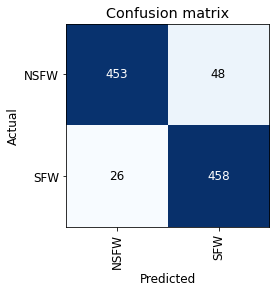

In [57]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Confusion matrix

The main takeaway here is that **NSFW images were incorrectly classified about twice as often as SFW images**, which is not too great if our primary aim is to protect innocent people's eyeballs and sensibilities from unsavoury content.

If this were a commercial NSFW filter, we would prefer to **err on the side of caution** - flagging as many of the NSFW images as possible at the expense of catching a few of the innocent ones too. 

One way to achieve this could simply be to **change the threshold** of the inference score so that we cast a wider net, increasing recall for the NSFW category while reducing overall precision. Luckily, there are many other ways in which we can improve our model before having to consider this option.

Next, we're going to take a look at those cases where the model was most ***confidently incorrect***, that is, the misclassified images with the highest losses. 

## Misclassified images

Below are 9 of the **most badly misclassified** images. Again, I'm not displaying them for obvious reasons. In all cases, the model assigned a probability of 1 to the images - meaning it was 100% sure they belonged to the incorrect class. Ouch!

**Main takeaways:**

- 3 of the images were of the same picture coming from Tumblr displaying the text "the image you're requesting is no longer available"
- 1 is a drawing with an SFW picture but NSFW text
- 4 of the images are mislabeled in the dataset
- The remaining image is correctly labeled - it shows a couple having sex.

To summarize, all but one of these images were misclassified because of **issues with the dataset**. Some of the images are in the **wrong category**, or are an artifact of **missing links** when downloading them from the internet. Drawings and images featuring heavy text content could potentially be excluded altohether, or limited to cartoons/hentai.

This is good news because it means that we could potentially see the accuracy improve just by **cleaning and improving the overall quality of the dataset**.

In [ ]:
# Only for the brave! 
interp.plot_top_losses(9, nrows=3)

## Conclusion

This experiment shows that transfer learning with ResNet50 and a custom NSFW dataset is a promising baseline for further explorations, both in terms of accuracy and a reasonable training time.

Some possible next steps would be **cleaning the dataset** to reduce noise and using **data augmentation** to reduce overfitting. 

Simply **adding more images** is another possibility, although I would have to test training times in TF-Keras too (quite a bit slower, in my experience) to see if that is feasible with my setup.